In [1]:
#Import libraries
import os, torch, time
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
from pathlib import Path

from torch.utils.data import DataLoader

from torchvision import models
from torchsummary import summary
from torchvision.transforms import transforms
from torchvision.io import read_image
from torchvision.utils import save_image

from PIL import Image 

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
# def plot_images(original_images, output_images, n=2):
#     """
#     Plots the original and output images side by side for comparison.
    
#     Parameters:
#         original_images (torch.Tensor): The original images.
#         output_images (torch.Tensor): The output images generated by the model.
#         n (int): Number of images to plot.
#     """
#     # Normalize and convert the images if necessary
#     original_images = original_images[:n].float() / 255.  # Assuming the images are in the range [0, 255]
#     output_images = output_images[:n].float() / 255.  # Same assumption for the output images
    
#     if original_images.max() > 1:
#         original_images = original_images / original_images.max()
#     if output_images.max() > 1:
#         output_images = output_images / output_images.max()

#     # Make a grid of the original and output images
#     original_grid = vutils.make_grid(original_images, padding=2, normalize=True)
#     output_grid = vutils.make_grid(output_images, padding=2, normalize=True)

#     # Plotting
#     fig, ax = plt.subplots(1, 2, figsize=(n*3, 3), dpi=100)
#     ax[0].imshow(original_grid.permute(1, 2, 0).numpy())
#     ax[0].set_title('Original Images')
#     ax[0].axis('off')

#     ax[1].imshow(output_grid.permute(1, 2, 0).numpy())
#     ax[1].set_title('Output Images')
#     ax[1].axis('off')

#     plt.show()


## Move the relevant files into train, test and validation directories

We will move the files into train, test and validation directories based on whether it is melanoma or non-melanoma.

In [ ]:
# # Read the groundtruth CSV file for train data
# train_name = 'ISIC2018_Task3_Training_GroundTruth'
# train_labels = pd.read_csv(f"{train_name}/{train_name}.csv")

In [ ]:
# train_labels

The table above will be used to determine if an image is melanoma-related or not. We write a function below to categorize images based on whether they are melanoma related or not.

In [ ]:
# #write a function to do the same for validation and test
# def categorize_image(paramtype):
#     #get the name of groundtruth
#     name = f'ISIC2018_Task3_{paramtype}_GroundTruth'
#     labels = pd.read_csv(f"{name}/{name}.csv")
    
#     #Move files from the 'ISIC2018_Task3_Training_Input' to either 'train/melanoma' or 'train/no_melanoma' directory.
#     for img_name, label in tqdm(labels[['image','MEL']].values.tolist()):
#         #define source path
#         source_path = f'ISIC2018_Task3_{paramtype}_Input/ISIC2018_Task3_{paramtype}_Input/{img_name}.jpg'

#         #if image is melanoma-related.
#         if label:
#             dest_path = f'{paramtype}/melanoma/{img_name}.jpg'
#         else:
#             dest_path = f'{paramtype}/no_melanoma/{img_name}.jpg'

#         #move the file from source to dest
#         os.rename(source_path, dest_path)
        
    
    

In [ ]:
# categorize_image('Training')

In [ ]:
# categorize_image('Validation')

In [ ]:
# categorize_image('Test')

Now, we will look at how many of the images are melanoma related and how many are not for training, validation and test.

In [ ]:
# def count_melanoma(paramtype):
#     #get the name of groundtruth
#     name = f'ISIC2018_Task3_{paramtype}_GroundTruth'
#     labels = pd.read_csv(f"{name}/{name}.csv")
#     return labels[['MEL']].value_counts()

In [ ]:
# count_melanoma('Training')

In [ ]:
# count_melanoma('Validation')

In [ ]:
# count_melanoma('Test')

We observe a distinct class imbalance in the samples. We will need to perform further transformations for augmenting the melanoma dataset by at least 8 fold. First, we will do augmentation for one image.

In [ ]:
# img = Image.open('Training/melanoma/ISIC_0024315.jpg')

In [ ]:
# # Display the image
# plt.imshow(img) # PyTorch tensors are in CxHxW and matplotlib expects HxWxC format, so we permute the tensor
# plt.axis('off') # Hide the axis
# plt.show()

As MobileNetv3 requires the image inputs in 224 x 224 x 3 format with normalized inputs against that of imagenet, we need to ensure that our training images for melanoma positive cases are augmented with a centercrop at the end to ensure all the melanoma images follow the same guidelines and normalized against the mean and standard deviation of all the images from ImageNet.

Here are the means and std for every R,G and B channels for imagenet [1]:
- R: (0.485, 0.229)
- G: (0.456, 0.224)
- B: (0.406, 0.225)

[1] https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2


In [ ]:
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms

# augmented_images = []

# # Initialize a figure
# fig, axs = plt.subplots(4, 2, figsize=(10, 10)) # Create a 4x4 grid of subplots
# axs = axs.flatten() # Flatten the 2D array of axes to easily loop through it


# for i in range(8): # Adjust the loop to fill the 4x4 grid
#     # Transform the image (adjust these transforms depending on your image)
#     transform = transforms.Compose([
#         transforms.RandomResizedCrop(size=256, scale=(0.2, 1.0)),
#         transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ])
    
#     out = transform(img)
#     imgname = f'sample/ISIC_0024315_v{i}.jpg'
#     save_image(out, imgname)
    
#     # Display the image on subplot
#     axs[i].imshow(out.permute(1, 2, 0)) # PyTorch tensors are in CxHxW and matplotlib expects HxWxC format, so we permute the tensor
#     axs[i].axis('off') # Hide the axis

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [ ]:
# #define the melanoma train folder
# melanoma_train = 'Training/melanoma'

# img_files = [file for file in os.listdir(melanoma_train) if len(file.split('.'))>1 and file.split('.')[1]=='jpg']

# #check if augmented directory for training images exist - if not make the directory
# if os.path.exists(os.path.join("Training", "melanoma", "augmented_images")) is False:
#     os.makedirs(os.path.join("Training", "melanoma", "augmented_images"))

# # iterate through every melanoma file - monitor progress using tqdm progressbar
# for f in tqdm(img_files):
#     #read the image input
#     img = Image.open(os.path.join("Training", "melanoma", f))
    
#     # we are going to augment it 8 times to increase 8-fold.
#     for i in range(8):
#         #define the data augmentation
#         # Transform the image (adjust these transforms depending on your image)
#         transform = transforms.Compose([
#             transforms.RandomResizedCrop(size=256, scale=(0.2, 1.0)),
#             transforms.RandomHorizontalFlip(),
#             transforms.CenterCrop(size=224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406],
#                                  [0.229, 0.224, 0.225])
#         ])

#         #apply augmentation on each image.
#         out = transform(img)

#         #store to a subdirectory 'augmented_img'
#         imgname = f.split('.')[0]
#         imgpath = os.path.join("Training", "melanoma", "augmented_images", f'{imgname}_v{i}.jpg')
#         save_image(out, imgpath)
    


For the other images (training non-melanoma, validation and test), we will only do only the following steps:

    - resizing to (256, 256, 3)
    - centercrop to 224 x 224 for every channel
    - lastly normalize against the mean and standard devation
    
Considering this, we came up with a function to standardize the transformation

In [ ]:
# def standard_imgTransform(paramtype, melanoma_category):
#     '''
#     paramtype: Train/Test/Validation
#     melanoma_category: melanoma/no_melanoma
    
#     '''
#     #first get the transform directory
#     transform_directory = os.path.join(f'{paramtype}', f'{melanoma_category}')
    
#     #list all the image files
#     img_files = [file for file in os.listdir(transform_directory) if len(file.split('.'))>1 and file.split('.')[1]=='jpg']

#     #check if augmented directory for training images exist - if not make the directory
#     if os.path.exists(os.path.join(transform_directory, "augmented_images")) is False:
#         os.makedirs(os.path.join(transform_directory, "augmented_images"))
    
#     # iterate through every melanoma file - monitor progress using tqdm progressbar
#     for f in tqdm(img_files):
#         #read the image input
#         img = Image.open(os.path.join(f'{paramtype}', f'{melanoma_category}', f))
        
#         # for a single iteration, we will convert the image for the neural network
#         # define the data augmentation
#         # Transform the image (adjust these transforms depending on your image)
#         transform = transforms.Compose([
#             transforms.Resize(size=256),
#             transforms.CenterCrop(size=224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406],
#                                  [0.229, 0.224, 0.225])])
        
        
#         #apply augmentation on each image.
#         out = transform(img)

#         #store to a subdirectory 'augmented_img'
#         imgname = f.split('.')[0]
#         imgpath = os.path.join(transform_directory, "augmented_images", f'{imgname}_v1.jpg')
#         save_image(out, imgpath)
        
        

In [ ]:
# #create augmented images for training no-melanoma
# standard_imgTransform(paramtype='Training', melanoma_category='no_melanoma')

In [ ]:
# #create augmented images for validation
# standard_imgTransform(paramtype='Validation', melanoma_category='melanoma')

In [ ]:
# #create augmented images for validation
# standard_imgTransform(paramtype='Validation', melanoma_category='no_melanoma')

In [ ]:
# #create augmented images for validation
# standard_imgTransform(paramtype='Test', melanoma_category='melanoma')

In [ ]:
# #create augmented images for test
# standard_imgTransform(paramtype='Test', melanoma_category='no_melanoma')

Now that we have done this, we need to create a dataloader object in Pytorch. However, it expects the augmented images (both melanoma and non-melanoma) within a central directory. With this in mind, we will manually do the following:

    1. Archive the current training, validation and test directories.
    2. Move only the augmented images from the training, validation and test directories to the newly created training, test and validation directories. e.g. 'Training/melanoma/augmented_images/<filename.jpg>' will be moved to 'Training_augmented/melanoma/<filename.jpg>'.

In [ ]:
# data['train']

# Transfer Learning

Here, we will leverage a MobileNetV2 model through fine-tuning the last layer.

In [3]:
import torch

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


In [4]:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.labels = [item[1] for item in dataset.imgs]
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in set(self.labels)}

    def __getitem__(self, index):
        img1, label1 = self.dataset.imgs[index]
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[label1])
        negative_label = np.random.choice(list(set(self.labels) - set([label1])))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        img2 = self.dataset.imgs[positive_index][0]
        img3 = self.dataset.imgs[negative_index][0]
        img1 = Image.open(img1).convert("RGB")
        img2 = Image.open(img2).convert("RGB")
        img3 = Image.open(img3).convert("RGB")
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return img1, img2, img3

    def __len__(self):
        return len(self.dataset)


In [5]:
# Set train and valid directory paths
train_directory = 'Training_Augmented'
valid_directory = 'Validation_Augmented'
test_directory = 'Test_Augmented'

# Batch size
bs = 32

# Number of classes
num_classes = 2

#define a standard transform to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=transform),
    'valid': datasets.ImageFolder(root=valid_directory, transform=transform),
    'test': datasets.ImageFolder(root=test_directory, transform=transform)
}

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])



In [6]:
import torch.nn as nn
from torchvision.models import resnet50
import numpy as np

class TripletNetwork(nn.Module):
    def __init__(self, embedding_size=128):
        super(TripletNetwork, self).__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Sequential(torch.nn.Linear(self.backbone.fc.in_features, 256),torch.nn.ReLU(),torch.nn.Dropout(0.7),torch.nn.Linear(256, 1),torch.nn.Sigmoid())  # Correct usage without dim=1

    def forward(self, x):
        embedding = self.backbone(x)
        return embedding



In [7]:
train_dataset = TripletDataset(dataset=data['train'], transform=transform)
train_data = DataLoader(train_dataset, batch_size=bs, shuffle=True)

valid_dataset = TripletDataset(dataset=data['valid'], transform=transform)
valid_data = DataLoader(valid_dataset, batch_size=bs, shuffle=True)

test_dataset = TripletDataset(dataset=data['test'], transform=transform)
test_data = DataLoader(test_dataset, batch_size=bs, shuffle=True)



In [8]:
import torch
import torchvision.models as models
# Instantiate the model
triplet_network = TripletNetwork(embedding_size=64).to(device)

for param in triplet_network.parameters():
    param.requires_grad = False


C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
summary(triplet_network)

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              (75,008)
|    |    └─Bottleneck: 3-2              (70,400)
|    |    └─Bottleneck: 3-3              (70,400)
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              (379,392)
|    |    └─Bottleneck: 3-5              (280,064)
|    |    └─Bottleneck: 3-6              (280,064)
|    |    └─Bottleneck: 3-7              (280,064)
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              (1,512,448)
|    |    └─Bottleneck: 3-9              (1,117,184)
|    |    └─Bottleneck: 3-10             (1,117,184)
|    |    └─Bottleneck: 3-11             (1,117,184)
|    |    └─Bottleneck: 3

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              (75,008)
|    |    └─Bottleneck: 3-2              (70,400)
|    |    └─Bottleneck: 3-3              (70,400)
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              (379,392)
|    |    └─Bottleneck: 3-5              (280,064)
|    |    └─Bottleneck: 3-6              (280,064)
|    |    └─Bottleneck: 3-7              (280,064)
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              (1,512,448)
|    |    └─Bottleneck: 3-9              (1,117,184)
|    |    └─Bottleneck: 3-10             (1,117,184)
|    |    └─Bottleneck: 3-11             (1,117,184)
|    |    └─Bottleneck: 3

In [10]:
# Unfreeze the parameters of the last residual block and the embedding layer
for param in triplet_network.backbone.layer4.parameters():
    param.requires_grad = True

In [11]:
summary(triplet_network)

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              (75,008)
|    |    └─Bottleneck: 3-2              (70,400)
|    |    └─Bottleneck: 3-3              (70,400)
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              (379,392)
|    |    └─Bottleneck: 3-5              (280,064)
|    |    └─Bottleneck: 3-6              (280,064)
|    |    └─Bottleneck: 3-7              (280,064)
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              (1,512,448)
|    |    └─Bottleneck: 3-9              (1,117,184)
|    |    └─Bottleneck: 3-10             (1,117,184)
|    |    └─Bottleneck: 3-11             (1,117,184)
|    |    └─Bottleneck: 3

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              (75,008)
|    |    └─Bottleneck: 3-2              (70,400)
|    |    └─Bottleneck: 3-3              (70,400)
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              (379,392)
|    |    └─Bottleneck: 3-5              (280,064)
|    |    └─Bottleneck: 3-6              (280,064)
|    |    └─Bottleneck: 3-7              (280,064)
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              (1,512,448)
|    |    └─Bottleneck: 3-9              (1,117,184)
|    |    └─Bottleneck: 3-10             (1,117,184)
|    |    └─Bottleneck: 3-11             (1,117,184)
|    |    └─Bottleneck: 3

In [12]:


# Assuming you replaced the fully connected layer with an embedding layer
for param in triplet_network.backbone.fc.parameters():
    param.requires_grad = True





In [13]:
next(iter(train_data))[1].reshape(-1, 1).shape

torch.Size([4816896, 1])

In [14]:
import torch
from torch.optim import Adam
from torch.nn import TripletMarginLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

epochs = 30
patience = 3  # For early stopping
best_valid_loss = float('inf')
early_stopping_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
triplet_network.to(device)
optimizer = Adam(triplet_network.parameters(), lr=0.001,weight_decay=1e-2)
loss_func = TripletMarginLoss(margin=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

history = []

for epoch in tqdm(range(epochs)):
    epoch_start = time.time()
    train_loss, valid_loss = 0.0, 0.0
    correct_train, correct_valid = 0, 0
    total_train, total_valid = 0, 0
    
    triplet_network.train()
    for batch_idx, (anchor, positive, negative) in enumerate(train_data):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        optimizer.zero_grad()
        anchor_embed = triplet_network(anchor)
        positive_embed = triplet_network(positive)
        negative_embed = triplet_network(negative)
        
        loss = loss_func(anchor_embed, positive_embed, negative_embed)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate "accuracy"
        with torch.no_grad():
            dist_positive = (anchor_embed - positive_embed).pow(2).sum(1)  # Euclidean distance
            dist_negative = (anchor_embed - negative_embed).pow(2).sum(1)
            correct_train += (dist_positive < dist_negative).sum().item()
            total_train += anchor.size(0)
    
    scheduler.step()
    triplet_network.eval()
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in enumerate(valid_data):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embed = triplet_network(anchor)
            positive_embed = triplet_network(positive)
            negative_embed = triplet_network(negative)
            
            loss = loss_func(anchor_embed, positive_embed, negative_embed)
            valid_loss += loss.item()
            
            # Calculate "accuracy"
            dist_positive = (anchor_embed - positive_embed).pow(2).sum(1)
            dist_negative = (anchor_embed - negative_embed).pow(2).sum(1)
            correct_valid += (dist_positive < dist_negative).sum().item()
            total_valid += anchor.size(0)
    
    avg_train_loss = train_loss / len(train_data)
    avg_valid_loss = valid_loss / len(valid_data)
    train_accuracy = correct_train / total_train
    valid_accuracy = correct_valid / total_valid
    
    history.append([avg_train_loss, avg_valid_loss, train_accuracy, valid_accuracy])
    
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter > patience:
            print("Early stopping triggered.")
            break

    epoch_end = time.time()
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}, Time: {epoch_end - epoch_start:.2f}s")


  3%|██▋                                                                             | 1/30 [09:15<4:28:21, 555.24s/it]

Epoch 1: Train Loss: 0.7103, Train Acc: 0.6872, Valid Loss: 0.9535, Valid Acc: 0.6684, Time: 555.24s



  7%|█████▎                                                                          | 2/30 [24:45<6:02:05, 775.93s/it]

Epoch 2: Train Loss: 0.5985, Train Acc: 0.7420, Valid Loss: 0.8688, Valid Acc: 0.7047, Time: 930.41s



 10%|████████                                                                        | 3/30 [35:10<5:18:04, 706.85s/it]

Epoch 3: Train Loss: 0.5293, Train Acc: 0.7844, Valid Loss: 0.7462, Valid Acc: 0.6788, Time: 624.64s



 13%|██████████▋                                                                     | 4/30 [45:32<4:51:50, 673.48s/it]

Epoch 4: Train Loss: 0.4824, Train Acc: 0.8073, Valid Loss: 0.6517, Valid Acc: 0.7461, Time: 622.34s



 17%|█████████████▎                                                                  | 5/30 [51:30<3:53:12, 559.70s/it]

Epoch 5: Train Loss: 0.4321, Train Acc: 0.8285, Valid Loss: 0.7074, Valid Acc: 0.7461, Time: 357.94s



 20%|████████████████                                                                | 6/30 [57:27<3:16:21, 490.88s/it]

Epoch 6: Train Loss: 0.3950, Train Acc: 0.8461, Valid Loss: 0.5072, Valid Acc: 0.7720, Time: 357.28s



 23%|██████████████████▏                                                           | 7/30 [1:03:25<2:51:30, 447.41s/it]

Epoch 7: Train Loss: 0.3686, Train Acc: 0.8582, Valid Loss: 0.9711, Valid Acc: 0.7098, Time: 357.92s



 27%|████████████████████▊                                                         | 8/30 [1:09:24<2:33:40, 419.12s/it]

Epoch 8: Train Loss: 0.3462, Train Acc: 0.8698, Valid Loss: 0.7651, Valid Acc: 0.7047, Time: 358.55s



 30%|███████████████████████▍                                                      | 9/30 [1:15:19<2:19:42, 399.17s/it]

Epoch 9: Train Loss: 0.3307, Train Acc: 0.8767, Valid Loss: 0.6412, Valid Acc: 0.7409, Time: 355.30s



 30%|███████████████████████▍                                                      | 9/30 [1:21:15<3:09:37, 541.77s/it]

Early stopping triggered.


In [15]:
history

[[0.7103083480945396,
  0.9534643292427063,
  0.6872402560934516,
  0.6683937823834197],
 [0.5984569246775372,
  0.8688002143587384,
  0.7419970796360777,
  0.7046632124352331],
 [0.5293145984464744,
  0.7461527415684291,
  0.784398517353701,
  0.6787564766839378],
 [0.4823873014167567,
  0.6517212986946106,
  0.8073121419746153,
  0.7461139896373057],
 [0.4321422980600028,
  0.7073630477700915,
  0.8284847804110974,
  0.7461139896373057],
 [0.3950255791685098,
  0.5072405295712608,
  0.8460631247893968,
  0.772020725388601],
 [0.3686463620573871,
  0.9711195656231472,
  0.8581938672357632,
  0.7098445595854922],
 [0.34617290187031835,
  0.7651008878435407,
  0.8698191620801977,
  0.7046632124352331],
 [0.33073798351698763,
  0.6412186452320644,
  0.8766707851286083,
  0.7409326424870466],
 [0.3103868189389873,
  0.5933979068483625,
  0.8881275974390654,
  0.7202072538860104]]

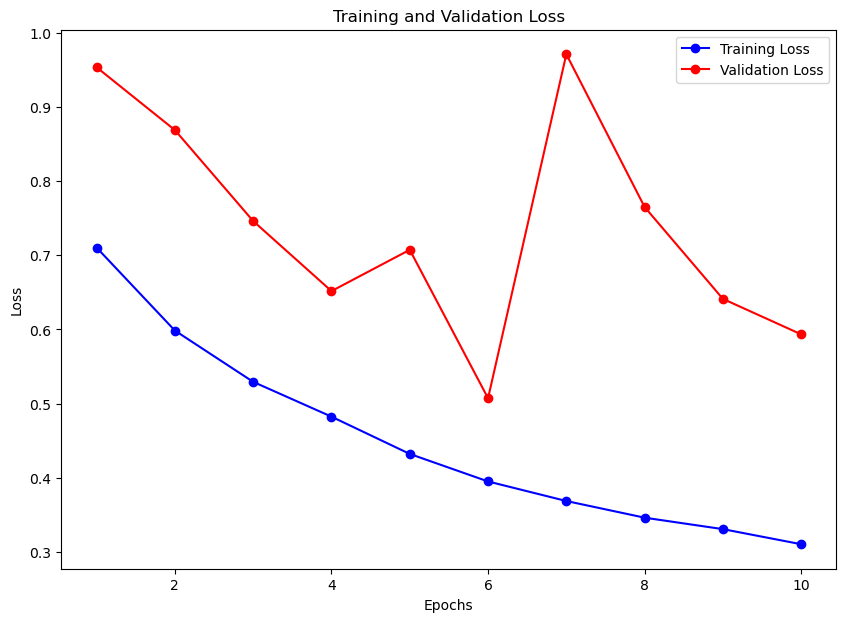

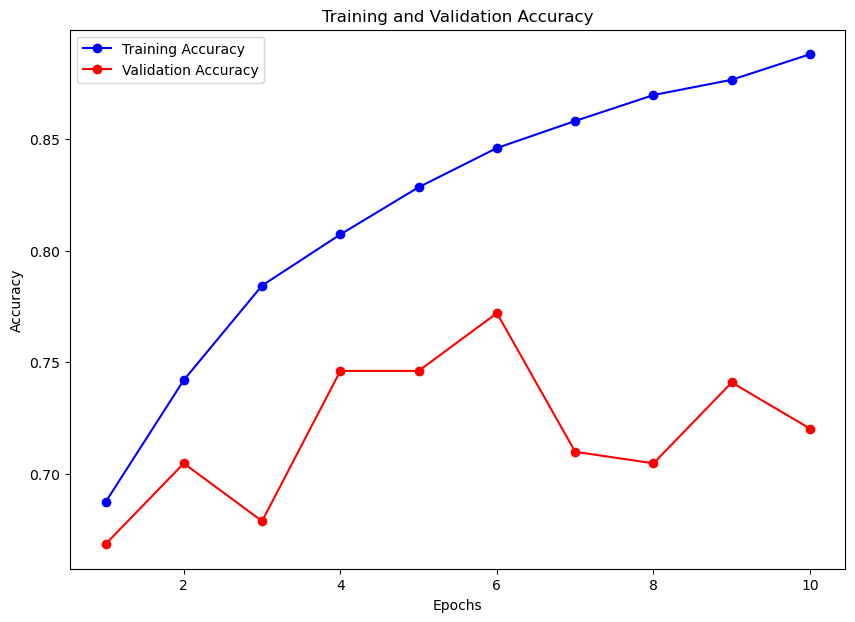

In [18]:
import matplotlib.pyplot as plt

# Unpack the history into separate lists for plotting
train_losses, valid_losses, train_accs, valid_accs = zip(*history)

epochs = range(1, len(history) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
plt.plot(epochs, valid_accs, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Based on both the graphs, we corroborate that training loss decreases as the number of epochs increases. To support the observation further, we also observe that while the training loss decreases, the training accuracy tends to go up. However, the same cannot be said about the validation accuracy and loss. Both the validation loss and accuracy shows an erratic trend over the number of epochs, suggestive of how the model's performance on validation dataset is inconsistent probably due to overfitting on training dataset and lack of generalization to new unseen data.

As we ascertain that the overfitting on training dataset is probably due to the very small sample size of validation dataset that causes the results (accuracy and loss) to deviate widely from epoch to epoch, we would look into increasing the volume of validation dataset. In addition, we also propose to look into regularization techniques requiring hyperparameter tunning to improve model efficiency.

In [17]:
def test_model(model, test_loader, device=torch.device("cuda")):
    """
    Test the trained model on the test dataset and compute performance metrics.
    
    Args:
        model: The trained PyTorch model to evaluate.
        test_loader: DataLoader for the test dataset.
        device: The device to use for inference (default: cpu).
    Returns:
        Performance metrics such as accuracy, precision, recall, etc.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            # Generate embeddings
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            
            # Compute distances
            dist_positive = (anchor_embed - positive_embed).pow(2).sum(1)
            dist_negative = (anchor_embed - negative_embed).pow(2).sum(1)
            
            # Compare distances
            correct += (dist_positive < dist_negative).sum().item()
            total += anchor.size(0)
    
    accuracy = correct / total
    return accuracy

# Example usage:
test_accuracy = test_model(triplet_network, test_data, device)
print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.673941798941799
